In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import random
import os
from torch.utils.data import Dataset, DataLoader
from torch import nn
import albumentations as A
from torch.utils.data.sampler import WeightedRandomSampler
from ignite.metrics import Recall, Precision, Accuracy
from sklearn import metrics
import codecs
from efficientnet_pytorch import model as enet
from sklearn.model_selection import StratifiedKFold

In [22]:
torch.cuda.empty_cache()

### Config

In [23]:
conf_dict = {
    "batch_size": 8,
    "learn_rate": 1e-3,
    "min_learn_rate": 1e-6,
    "weight_decay": 1e-4,
    "epochs": 10,
    "folds": 5,

    "transfer_model_name": "efficientnet-b1",
    "model": "schnaufnet_trained",
    "model_to_load": "schnaufnet_trained.pth",

    "input_dir": "../input/seti-breakthrough-listen/",
    "train_dir": "../input/seti-breakthrough-listen/train/",
    "train_csv": "train_labels.csv",
    "test_dir": "../input/seti-breakthrough-listen/test/",
    "test_csv": "sample_submission.csv",
    "efficientnetdir": "../input/efficientnetpytorch/",
    "height": 256,
    "width": 256,

    "origin_height": 273,
    "origin_width": 256,

    "use_all": True,
    "only_use": 1000,
    "behaviours": {
        "all": "all",
        "weighted": "weighted",
    },
    "split_until_ratio": (3 / 4),
    "load_model": False,
}
current_split_behaviour = conf_dict["behaviours"]["weighted"]
new_split_behaviour = conf_dict["behaviours"]["all"]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [24]:
def set_seed(seed=0):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

### Custom Dataset

In [25]:
class SETIDataset(Dataset):
	"""Dataset for training data"""
	def __init__(self, df, transform=None):
		self.df = df
		self.labels = self.df["target"].values
		self.file_names = self.df['file_path'].values
		self.transform = transform

	def __len__(self):
		return len(self.df)

	def __getitem__(self, idx):
		file_path = self.file_names[idx]
		image = np.load(file_path)
		image = image.astype(np.float32)
		image = np.vstack(image).T
		if self.transform:
			image = self.transform(image=image)['image']
		else:
			image = image[np.newaxis,:,:] # add dimension
			image = torch.from_numpy(image).float()
		image = torch.from_numpy(image).unsqueeze(dim=0)
		label = torch.tensor(self.labels[idx]).float()
		return image, label

In [26]:
class EfficientNetBackbone(nn.Module):
    def __init__(self, out_dim, load_schnaufnet_model=False):
        super(EfficientNetBackbone, self).__init__()
        print("Initializing Efficientnet Backbone")
        model_name = conf_dict["transfer_model_name"]
        self.efficientnet = enet.EfficientNet.from_pretrained(model_name)
        if load_schnaufnet_model:
            print("Loading pretrained schnaufnet model")
            model.load_state_dict(torch.load(conf_dict["model_to_load"]))
        self.first_layer = nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.final_layer = nn.Linear(self.efficientnet._fc.in_features, out_dim)
        self.efficientnet._fc = nn.Identity()

    def extract(self, x):
        return self.efficientnet(x)

    def forward(self, x):
        x = self.first_layer(x)
        x = self.extract(x)
        x = self.final_layer(x)
        return x

In [27]:
def split(train_index, val_index, behaviour="all"):
    train_df, val_df = df_train.iloc[train_index], df_train.iloc[val_index]
    
    dataset_train = SETIDataset(train_df, transform=get_transforms(data="train"))
    dataset_val = SETIDataset(val_df, transform=get_transforms(data="val"))

    if behaviour == conf_dict["behaviours"]["weighted"]:
        print("Using 50/50 weighted data...")
        labels = np.array(dataset_train.labels)
        class_counts = np.array(
            [len(np.where(labels == t)[0]) for t in np.unique(labels)])
        num_samples = sum(class_counts)
        class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
        weights = [class_weights[labels[i]] for i in range(int(num_samples))]
        sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
        train_dataloader = DataLoader(
            dataset_train, batch_size=conf_dict["batch_size"], sampler=sampler)
    elif behaviour == conf_dict["behaviours"]["all"]:
        print("Using original full data...")
        train_dataloader = DataLoader(
            dataset_train, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    val_dataloader = DataLoader(dataset_val, batch_size=conf_dict["batch_size"], shuffle=True)#, num_workers=2)
    print(f"Successfully splitted dataset!\n Trainbatches: {len(train_dataloader)}\n Validationbatches: {len(val_dataloader)}")
    return train_dataloader, val_dataloader

def get_0_1_batches_ratio(dataloader):
    print("dataloader length: ", len(dataloader))
    for i, (data, target) in enumerate(dataloader):
        print (f"batch index {i}, 0/1: {len(np.where(target.numpy() == 0)[0])}/{len(np.where(target.numpy() == 1)[0])}")

def get_0_1_ratio(dataloader, train):
    dataloader_0 = 0
    dataloader_1 = 0
    for i, (data, target) in enumerate(tqdm(dataloader)):
        dataloader_0 += len(np.where(target.numpy() == 0)[0])
        dataloader_1 += len(np.where(target.numpy() == 1)[0])
    dataloaderinformation = "train" if train else "val"
    print(f"{dataloaderinformation} dataloader 0/1 ratio: {dataloader_0}, {dataloader_1}")
    return train_dataloader, val_dataloader

In [28]:
def train_loop(model, train_dataloader, optimizer, loss_fn, scheduler, epoch_loss_list):
    print("Starting model training...")
    model.train()
    epoch_loss = 0
    num_batches = len(train_dataloader)

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    for (images, labels) in tqdm(train_dataloader, position=0, leave=True, desc='Training'):
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        predicted = torch.sigmoid(pred).round()
        accuracy.update((predicted, labels))
        precision.update((predicted, labels))
        recall.update((predicted, labels))

    avg_epoch_loss = epoch_loss / num_batches
    epoch_loss_list.append(avg_epoch_loss)
    print(f"""Training Error: \n 
        Accuracy: {100*accuracy.compute():>2f}%, \n
        Recall: {100*recall.compute():>2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """)
    with codecs.open('logs/schnaufNet2.0 train.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)

def validation_loop(model, val_dataloader, loss_fn):
    print("Starting model validation...")
    model.eval()

    epoch_loss = 0
    num_batches = len(val_dataloader)
    epoch_labels = []
    epoch_preds = []

    accuracy = Accuracy()
    precision = Precision()
    recall = Recall()

    with torch.no_grad():
        for (images, labels) in tqdm(val_dataloader, position=0, leave=True, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss = loss_fn(pred.view(labels.size(0)), labels.to(torch.float32))
            epoch_loss += loss.item()

            predicted_raw = torch.sigmoid(pred)
            predicted = predicted_raw.round()

            accuracy.update((predicted, labels))
            precision.update((predicted, labels))
            recall.update((predicted, labels))
            
            labels = labels.detach().cpu().numpy().tolist()
            predicted_raw = predicted_raw.detach().cpu().numpy().tolist()
            epoch_labels.extend(labels)
            epoch_preds.extend(predicted_raw)

    avg_epoch_loss = epoch_loss / num_batches
    print(f"""Validation Error: \n
        Accuracy: {100*accuracy.compute():2f}%, \n
        Recall: {100*recall.compute():2f}%, \n
        Precision: {100*precision.compute():>2f}%, \n
        Avg loss: {avg_epoch_loss:>2f} \n
    """)
    with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
        up.write(f"""Validation Error: \n
            Accuracy: {100*accuracy.compute():2f}%, \n
            Recall: {100*recall.compute():2f}%, \n
            Precision: {100*precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)
    return epoch_labels, epoch_preds

In [29]:
def get_transforms(data):
    if data == 'train':
        return A.Compose([
            A.Resize(conf_dict["height"], conf_dict["width"]),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
        ])
    elif data == 'val':
        return A.Compose([
            A.Resize(conf_dict["height"], conf_dict["width"]),
        ])

def get_file_path(target, directory):
    return directory + "{}/{}.npy".format(target[0], target)

Initializing Efficientnet Backbone
Loaded pretrained weights for efficientnet-b1
Fold 1/5 | Epoch 1/10
-------------------------------
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [37:08<00:00,  2.69it/s]  


Training Error: 
 
        Accuracy: 63.202083%, 

        Recall: 48.660770%, 

        Precision: 68.191964%, 

        Avg loss: 0.615420 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:23<00:00,  2.98it/s]


Validation Error: 

        Accuracy: 91.008333%, 

        Recall: 36.583333%, 

        Precision: 57.992074%, 

        Avg loss: 0.448751 

    
Val ROC AUC Score: 0.741328587962963


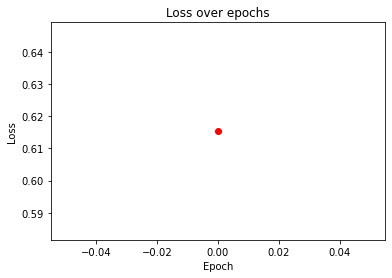

Fold 1/5 | Epoch 2/10
-------------------------------
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [36:59<00:00,  2.70it/s] 


Training Error: 
 
        Accuracy: 67.627083%, 

        Recall: 52.180563%, 

        Precision: 76.069664%, 

        Avg loss: 0.559112 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:16<00:00,  3.02it/s]


Validation Error: 

        Accuracy: 89.591667%, 

        Recall: 41.750000%, 

        Precision: 47.668887%, 

        Avg loss: 0.492041 

    
Val ROC AUC Score: 0.7613603395061728


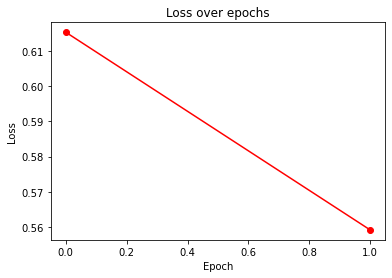

Fold 1/5 | Epoch 3/10
-------------------------------
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [38:22<00:00,  2.61it/s]  


Training Error: 
 
        Accuracy: 69.266667%, 

        Recall: 52.315587%, 

        Precision: 79.050561%, 

        Avg loss: 0.543345 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:24<00:00,  2.97it/s]

Validation Error: 

        Accuracy: 91.216667%, 

        Recall: 40.083333%, 

        Precision: 58.946078%, 

        Avg loss: 0.399930 

    
Val ROC AUC Score: 0.7538427083333333


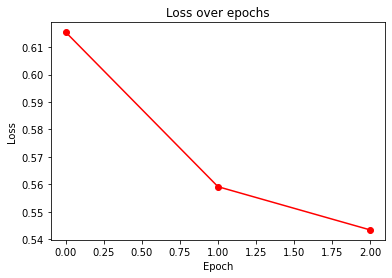

Fold 1/5 | Epoch 4/10
-------------------------------
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [37:59<00:00,  2.63it/s] 


Training Error: 
 
        Accuracy: 70.102083%, 

        Recall: 53.572921%, 

        Precision: 79.820684%, 

        Avg loss: 0.533404 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:17<00:00,  3.01it/s]

Validation Error: 

        Accuracy: 89.300000%, 

        Recall: 44.750000%, 

        Precision: 46.373057%, 

        Avg loss: 0.484692 

    
Val ROC AUC Score: 0.7540822530864197


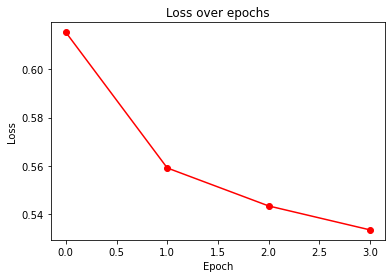

Fold 1/5 | Epoch 5/10
-------------------------------
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [37:52<00:00,  2.64it/s] 


Training Error: 
 
        Accuracy: 70.241667%, 

        Recall: 54.559106%, 

        Precision: 79.417122%, 

        Avg loss: 0.529918 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:21<00:00,  2.99it/s]

Validation Error: 

        Accuracy: 89.400000%, 

        Recall: 43.583333%, 

        Precision: 46.779964%, 

        Avg loss: 0.450980 

    
Val ROC AUC Score: 0.756112075617284


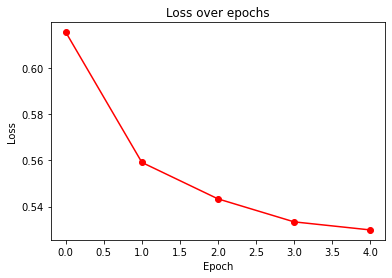

Fold 1/5 | Epoch 6/10
-------------------------------
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [38:23<00:00,  2.60it/s]  


Training Error: 
 
        Accuracy: 70.839583%, 

        Recall: 55.800671%, 

        Precision: 80.250000%, 

        Avg loss: 0.522335 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:19<00:00,  3.00it/s]


Validation Error: 

        Accuracy: 91.225000%, 

        Recall: 40.916667%, 

        Precision: 58.802395%, 

        Avg loss: 0.415518 

    
Val ROC AUC Score: 0.7576769290123456


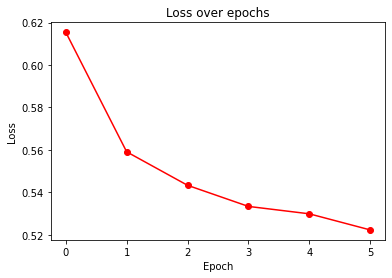

Fold 1/5 | Epoch 7/10
-------------------------------
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [37:59<00:00,  2.63it/s] 


Training Error: 
 
        Accuracy: 71.104167%, 

        Recall: 55.412016%, 

        Precision: 80.527371%, 

        Avg loss: 0.519224 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:39<00:00,  2.89it/s]

Validation Error: 

        Accuracy: 90.600000%, 

        Recall: 39.500000%, 

        Precision: 54.109589%, 

        Avg loss: 0.397269 

    
Val ROC AUC Score: 0.748189776234568


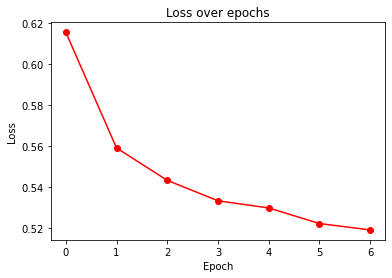

Fold 1/5 | Epoch 8/10
-------------------------------
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [38:11<00:00,  2.62it/s]  


Training Error: 
 
        Accuracy: 71.168750%, 

        Recall: 56.120754%, 

        Precision: 80.508727%, 

        Avg loss: 0.516798 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:18<00:00,  3.01it/s]


Validation Error: 

        Accuracy: 87.808333%, 

        Recall: 44.750000%, 

        Precision: 40.164547%, 

        Avg loss: 0.419073 

    
Val ROC AUC Score: 0.7622040895061728


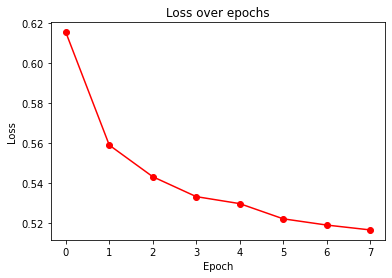

Fold 1/5 | Epoch 9/10
-------------------------------
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [37:44<00:00,  2.65it/s]  


Training Error: 
 
        Accuracy: 71.929167%, 

        Recall: 57.934697%, 

        Precision: 80.721429%, 

        Avg loss: 0.508109 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:28<00:00,  2.95it/s]


Validation Error: 

        Accuracy: 87.508333%, 

        Recall: 47.833333%, 

        Precision: 39.668279%, 

        Avg loss: 0.452788 

    
Val ROC AUC Score: 0.7698146219135802


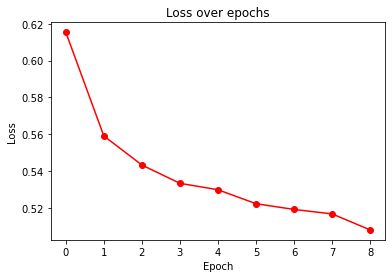

Fold 1/5 | Epoch 10/10
-------------------------------
Using 50/50 weighted data...
Successfully splitted dataset!
 Trainbatches: 6000
 Validationbatches: 1500
Starting model training...


Training: 100%|██████████| 6000/6000 [37:53<00:00,  2.64it/s] 


Training Error: 
 
        Accuracy: 71.997917%, 

        Recall: 57.598968%, 

        Precision: 80.956003%, 

        Avg loss: 0.510104 

    
Starting model validation...


Evaluating: 100%|██████████| 1500/1500 [08:26<00:00,  2.96it/s]

Validation Error: 

        Accuracy: 81.683333%, 

        Recall: 54.000000%, 

        Precision: 28.247602%, 

        Avg loss: 0.489013 

    
Val ROC AUC Score: 0.7671470293209877


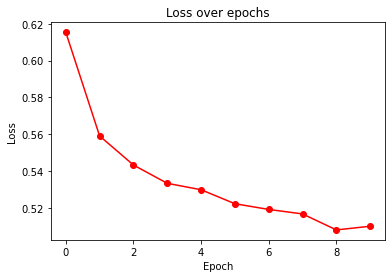

Training done! Best model in fold 0, epoch 8 with roc_auc of 0.7698146219135802


In [30]:
df_train = pd.read_csv(conf_dict["input_dir"] + conf_dict["train_csv"])
if not conf_dict["use_all"]:
    df_train = df_train[:conf_dict["only_use"]]
df_train["file_path"] = df_train["id"].apply(get_file_path, directory=conf_dict["train_dir"])

loss_fn = nn.BCEWithLogitsLoss() # weight=torch.tensor([1, 10])) # => 1er labels um das 10-fache relevanter machen
num_epochs = conf_dict["epochs"]
num_folds = conf_dict["folds"]
skf = StratifiedKFold(n_splits=num_folds)

with codecs.open('logs/schnaufNet2.0 train.log', 'a') as up:
    up.write("------------------ new training ------------------")
with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
    up.write("------------------ new validation ------------------")

for fold, (train_index, val_index) in enumerate(skf.split(df_train, df_train["target"])):
    model = EfficientNetBackbone(out_dim=1, load_schnaufnet_model=conf_dict["load_model"])
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=conf_dict["learn_rate"], weight_decay=conf_dict["weight_decay"]) # torch.optim.SGD(model.parameters(), lr=conf_dict["learn_rate"]) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=conf_dict["epochs"], eta_min=conf_dict["min_learn_rate"], last_epoch=-1
    )
    best_roc_auc = 0
    best_roc_auc_fold = 1
    best_roc_auc_fold_epoch = 1
    epoch_train_loss_list = []
    for epoch in range(num_epochs):
        print(f"Fold {fold + 1}/{num_folds} | Epoch {epoch + 1}/{num_epochs}\n-------------------------------")
        # if epoch == math.floor(num_epochs * conf_dict["split_until_ratio"]):
        #     train_dataloader, val_dataloader = split(train_index, val_index, behaviour=new_split_behaviour)
        # else:
        #     train_dataloader, val_dataloader = split(train_index, val_index, behaviour=current_split_behaviour)
        train_dataloader, val_dataloader = split(train_index, val_index, behaviour=conf_dict["behaviours"]["weighted"]) # only behaviour 'all'
        train_loop(model, train_dataloader, optimizer, loss_fn, scheduler, epoch_train_loss_list)
        val_labels, val_predictions = validation_loop(model, val_dataloader, loss_fn)
        roc_auc = metrics.roc_auc_score(val_labels, val_predictions)
        print(f"Val ROC AUC Score: {roc_auc}")
        with codecs.open('logs/schnaufNet2.0 validation.log', 'a') as up:
            up.write(f"""
                Epoch={epoch}, Valid ROC AUC={roc_auc}\n
            """)
        if roc_auc > best_roc_auc:
            torch.save(model.state_dict(), "best_roc_auc_" + conf_dict["model"] + "-" + str(fold) + "-" + str(epoch) + ".pth")
            best_roc_auc = roc_auc
            best_roc_auc_fold = fold
            best_roc_auc_epoch = epoch
        plt.plot(epoch_train_loss_list, "ro-")
        plt.title("Loss over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    break # for test purposes only one fold
print(f"Training done! Best model in fold {best_roc_auc_fold}, epoch {best_roc_auc_epoch} with roc_auc of {best_roc_auc}")